# Chapter 4: Self-Abnegation in the Sonnets of Clare and Smith

In traditional accounts of Romantic literature, lyric poetry is central and is tightly defined in terms of the 'necessary self'. The Romantic lyric is an 'internalized quest romance' or 'upward spiral', in which the poet describes their experience of nature and moves towards a final recognition of their true identity. While this conception of the Romantic lyric has come under attack in recent years, no alternative understanding of the Romantic lyric has arisen to replace it. This is partly due to proponents of the 'New Lyric Studies', who argue that the only available definition of lyric poetry *is* the definition used in traditional scholarship on Romanticism. The only solution, claim the proponents of the New Lyric Studies, is to set aside the desire to define 'lyric poetry' at all.

In Chapter 4 of *Romanticism and the Contingent Self*, I consider the sonnets of Charlotte Smith and John Clare, two poets whose poems almost never culminate in a recognition of their true identity. Using the example of their sonnets, I try to show how an alternative understanding of the Romantic lyric is possible, one that makes room for a wider variety of poems in our conceptualisation of the 'lyric', while also allowing us to define what the lyric is with tolerable precision.

In this notebook, I generate all the tables and figures for Chapter 4 of the book.

In [69]:
%matplotlib inline

import os
from collections import Counter

from romanticself import SonnetCorpus
from romanticself import import_scheme_map
import pandas as pd
import seaborn as sns

sns.set_theme(palette="Greys")

In [14]:
sonnets = SonnetCorpus("data/sonnet-corpus/")
rs_map = import_scheme_map("data/sonnet-corpus/schemes.csv")

Extracting Wordsworth's sonnets from wwComplete.xml...
Extracting Smith's sonnets from smithComplete.xml...
Extracting Clare's sonnets from clareComplete.xml...
SonnetCorpus(Wordsworth: 514 [12], Smith: 93 [1], Clare: 638 [53])


## 4.1 Narrative: Against Closure

Which rhyme-schemes do Smith, Clare and Wordsworth prefer?

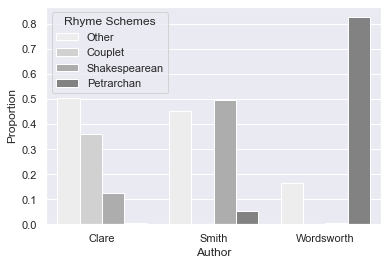

In [76]:
def plot_rhyme_schemes(corpus, normalize=True):
    
    x, hue, y = "Author", "Rhyme Schemes", "Proportion" if normalize else "Count"

    rhyme_schemes = pd.DataFrame([(author, rs_map[rhyme_scheme]) for author,rhyme_scheme in sonnets.yield_metadata("author", "rhyme_scheme")])
    rhyme_schemes.columns = [x, hue]

    rhyme_schemes_data = rhyme_schemes.groupby("Author").value_counts(normalize=normalize).rename(y).reset_index()

    return sns.barplot(data=rhyme_schemes_data, x=x, y=y, hue=hue).get_figure()

rhyme_plot = plot_rhyme_schemes(sonnets, True)
rhyme_plot.savefig("figures/figure_4_1.jpg", dpi=500)


In [112]:
def mean_rhyme_sounds_by_poet(corpus):

    def num_sounds(rhyme_scheme):
        # We can use 'max' to get the 'highest' letter in each rhyme-scheme, whose position in the alphabet
        # corresponds to the number of rhyme-sounds in the poem. For instance, if the highest letter is 'e',
        # it means there are 5 unique rhyme sounds
        letter_map = {letter:num+1 for num,letter in enumerate('abcdefghijklmnop')}
        return letter_map[max(rhyme_scheme)]

    rhyme_sounds = corpus.yield_metadata("author", "rhyme_scheme")
    scheme_data = pd.DataFrame([(author, num_sounds(scheme)) for author,scheme in rhyme_sounds])
    scheme_data.columns = ["Author", "Number of Sounds"]
    
    return scheme_data.groupby("Author").mean()

rhyme_sounds_table = mean_rhyme_sounds_by_poet(sonnets)
rhyme_sounds_table  # type: ignore



,Number of Sounds
Author,
Clare,6.224138
Smith,6.322581
Wordsworth,5.118677
